<a href="https://colab.research.google.com/github/Deep-Learning-Assignment/Deep-Learning-Project/blob/IT21161742_Kumari-P.D.L/Daraya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
from google.colab import drive
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Mount Google Drive
drive.mount('/content/drive')

# Path to dataset zip file in Google Drive
zip_file_path = '/content/drive/My Drive/Plant Village.zip'

# Directory to extract the files
extract_dir = '/content/Extracted_data'

# Create directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to /content/Extracted_data


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

# Path to the folder where your dataset is located
input_folder = '/content/Extracted_data/PlantVillage'

# Split dataset into train (70%), validation (20%), and test (10%)
splitfolders.ratio(input_folder, output="/content/split_data", seed=42, ratio=(.7, .2, .1))

print("Dataset has been split into training, validation, and test sets.")


Copying files: 20639 files [00:03, 5770.96 files/s]


Dataset has been split into training, validation, and test sets.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Create an ImageDataGenerator for the training set with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalize pixel values to [0, 1]
    rotation_range=40,    # Randomly rotate images by 40 degrees
    width_shift_range=0.2, # Shift the image horizontally by 20%
    height_shift_range=0.2, # Shift the image vertically by 20%
    shear_range=0.2,      # Apply shearing transformations
    zoom_range=0.2,       # Randomly zoom in on images
    horizontal_flip=True, # Flip images horizontally
    fill_mode='nearest'   # Fill any missing pixels after rotation/shift with nearest pixel
)

# Create ImageDataGenerator for validation and test sets (only rescale the images)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Define the directories for train, validation, and test sets
train_dir = '/content/split_data/train'
val_dir = '/content/split_data/val'
test_dir = '/content/split_data/test'

# Load the images and resize them to 224x224 (standard input size for VGG16)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize to 224x224
    batch_size=32,           # Batch size
    class_mode='categorical' # Since it's a multi-class classification
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 14440 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Found 2076 images belonging to 15 classes.


In [ ]:
num_classes = train_generator.num_classes  # Should return the number of classes
print(f"Number of classes: {num_classes}")

num_classes = 15  # Set this to the actual number of classes


Number of classes: 15


In [ ]:
batch = next(train_generator)

# Print the shape of the images and labels
print(f"Batch image shape: {batch[0].shape}")  # This should be (batch_size, 224, 224, 3)
print(f"Batch label shape: {batch[1].shape}")

Batch image shape: (32, 224, 224, 3)
Batch label shape: (32, 15)


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Define the input shape
input_tensor = Input(shape=(224, 224, 3))

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the first 20 layers
for layer in base_model.layers[:20]:
    layer.trainable = False

# Build the model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)                   # Add a Dropout layer
output = Dense(num_classes, activation='softmax')(x)  # Output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Print the model summary
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,141,327 (80.65 MB)

 Trainable params: 6,426,639 (24.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Set up a learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy', # Monitor validation accuracy
    factor=0.5,            # Reduce learning rate by half
    patience=3,            # Wait for 3 epochs before reducing
    min_lr=1e-6            # Minimum learning rate
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,              # Set the number of epochs
    callbacks=[lr_scheduler] # Add the learning rate scheduler
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


452/452 ━━━━━━━━━━━━━━━━━━━━ 245s 496ms/step - accuracy: 0.3698 - loss: 2.0158 - val_accuracy: 0.6912 - val_loss: 0.9770 - learning_rate: 1.0000e-04
Epoch 2/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 228s 456ms/step - accuracy: 0.6130 - loss: 1.2262 - val_accuracy: 0.7797 - val_loss: 0.7303 - learning_rate: 1.0000e-04
Epoch 3/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 207s 454ms/step - accuracy: 0.6737 - loss: 1.0124 - val_accuracy: 0.7972 - val_loss: 0.6302 - learning_rate: 1.0000e-04
Epoch 4/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 260s 450ms/step - accuracy: 0.7065 - loss: 0.9028 - val_accuracy: 0.8183 - val_loss: 0.5949 - learning_rate: 1.0000e-04
Epoch 5/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 205s 448ms/step - accuracy: 0.7229 - loss: 0.8554 - val_accuracy: 0.8384 - val_loss: 0.5348 - learning_rate: 1.0000e-04
Epoch 6/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 264s 453ms/step - accuracy: 0.7342 - loss: 0.8143 - val_accuracy: 0.8028 - val_loss: 0.5644 - learning_rate: 1.0000e-04
Epoch 7/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 261s 448ms/

In [ ]:
!pip install matplotlib


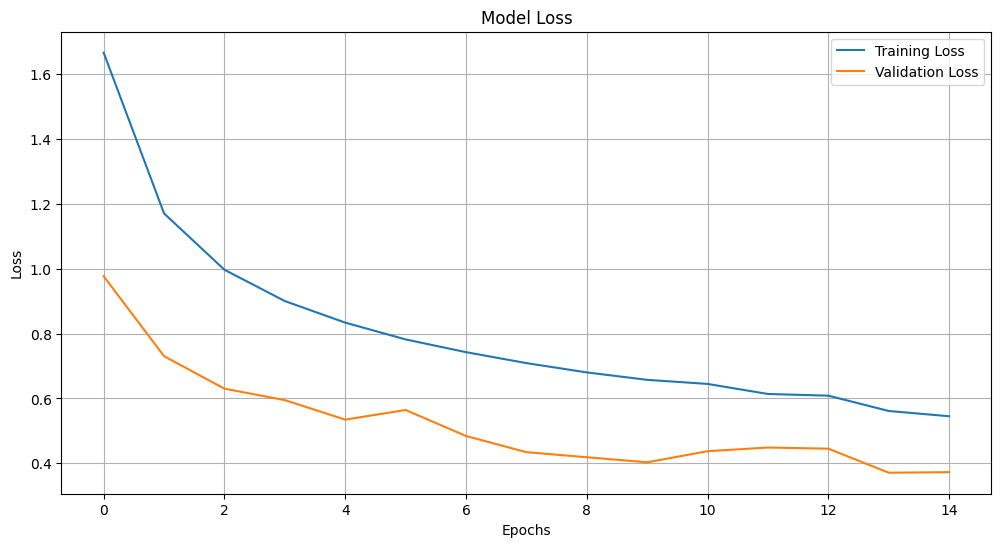

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
# Save the model to a file
model.save('food_disease_classification_model.h5')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
# Load the trained model
model = load_model('food_disease_classification_model.h5')


In [ ]:
def preprocess_image(image_path):
    # Load the image with the target size for VGG16
    image = load_img(image_path, target_size=(224, 224))
    # Convert the image to a numpy array
    image = img_to_array(image)
    # Scale the pixel values to [0, 1]
    image = image / 255.0
    # Expand dimensions to match the model input
    image = np.expand_dims(image, axis=0)
    return image


In [ ]:
def predict_image(image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path)
    # Make predictions
    predictions = model.predict(processed_image)
    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)[0]
    return predicted_class


In [ ]:
import os

def get_class_names(data_dir):
    class_names = sorted([folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))])
    return class_names

# Usage
data_dir = '/content/Extracted_data/PlantVillage'  # Replace with the path to your dataset directory
class_names = get_class_names(data_dir)

print("Class names:", class_names)

Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
# Replace these with your actual class names based on the folder structure
Class_names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']  # Add all classes

def get_class_name(class_index):
    return class_names[class_index]


In [ ]:
# Path to the test image
image_path = '/content/split_data/test/Tomato__Tomato_YellowLeaf__Curl_Virus/003bce78-28c9-4612-b148-f621e9a23bd4___YLCV_GCREC 5154.JPG'  # Replace with your image path

# Get predicted class index
predicted_class_index = predict_image(image_path)
# Get predicted class name
predicted_class_name = get_class_name(predicted_class_index)

print(f"Predicted class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Tomato__Tomato_YellowLeaf__Curl_Virus
